# fasttext 

Este modelo crea vectores en un espacio vectorial de $N$ dimensiones (N seleccionado por el usuario) que capturan la semántica del texto analizado

In [ ]:
!pip install fasttext

In [ ]:
!pip install xgboost

In [1]:
import fasttext
import xgboost as xgb
import json
import numpy as np

In [2]:
# Leer la información de un archivo
with open("ppc_suba_comentarios_limpios.json", "r") as f:
    comentarios = json.load(f)

In [3]:
# Creamos un archivo txt con todos los comentarios con los que vamos a entrenar fastText
with open("archivo_con_comentarios.txt", "w") as f:
    for c in comentarios:
        f.write(c['texto_nopunct'])
        f.write("\n")

In [4]:
# El modelo acepta muchos parámetros (leer la documentación: https://fasttext.cc/docs/en/options.html)
modelo = fasttext.train_unsupervised("archivo_con_comentarios.txt", dim=20)

In [5]:
for com in comentarios:
    com['vector'] = modelo.get_sentence_vector(com['texto_nopunct'])

# Preparar datos para XGBoost

La idea de pasar de comentarios a vectores es poder utilizar la información numérica de los vectores para entrenar un modelo para predecir cierta característica. En nuestro caso, queremos predecir la característica del puntaje.

Para ello, debemos tener una matriz `X` cuyas filas sean los vectores de los textos, y debemos tener un vector `y` cuyas componentes sean el valor que queremos predecir. A cada fila de X le corresponde una componente de `y`.

In [6]:
comentarios[0]

{'text': 'Parecía arroz del día anterior, trasnochado y de mal gusto',
 'author': 'Raul fernando',
 'previousOrders': '2',
 'previousReviews': '0',
 'date': '21 sep, 2019',
 'worstRating': '1',
 'ratingValue': '3.7',
 'bestRating': '5',
 'texto_nopunct': 'parecía arroz día anterior trasnochado mal gusto',
 'vector': array([-5.56163549e-01,  1.06958136e-01,  2.33587213e-02, -3.35367881e-02,
         3.42118699e-04, -1.12064362e-01,  3.09867978e-01, -4.78461869e-02,
         1.09451212e-01,  9.25285518e-02, -2.13167474e-01,  1.26039490e-01,
         1.01586543e-01,  2.36847587e-02, -2.81911731e-01, -1.66210607e-01,
        -1.85772210e-01,  2.92397976e-01,  7.91760068e-03, -3.85352761e-01],
       dtype=float32)}

In [7]:
X = np.array( [com['vector'] for com in comentarios] )
y = np.array( [float(com['ratingValue']) for com in comentarios] )

In [8]:
X.shape

(1170, 20)

In [9]:
y.shape

(1170,)

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [12]:
# Declaramos el objeto de regresor de XGBoost

reg = xgb.XGBRegressor(max_depth=3, learning_rate=0.1,
                         n_estimators=100)

In [13]:
reg.fit(X_train, y_train)

[08:20:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [14]:
y_train_predicted = reg.predict(X_train)

Para medir errores de regresión existen varias métricas. Nosotros nos vamos a concentrar en el error cuadrático medio. Este se define de la siguiente manera. Supongamos que tenemos los puntajes verdaderos de los comentarios. Denotamos el $i$-ésimo puntaje verdadero como $y_i$. Y denotamos la predicción del regresor del puntaje $i$-ésimo como $\hat{y}_i$. Por lo tanto, el error cuadrático medio es

$$\frac{1}{M}\sum_{i=1}^M (y_i - \hat{y}_i)^2$$

en donde $M$ es el número total de puntajes.

In [15]:
from sklearn.metrics import mean_squared_error

In [18]:
mean_squared_error(y_train_predicted, y_train)

0.6208267207997271

In [19]:
# También podemos ver un vector de errores para cada dato:
errvec_train = y_train - y_train_predicted

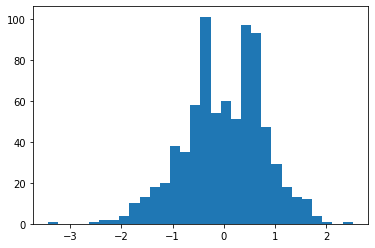

In [20]:
# Y podemos hacer un histograma de este para ver cómo está distribuido el error:
import matplotlib.pyplot as plt

plt.hist(errvec_train, bins=30)
plt.show()

In [21]:
# Ahora veamos esto para el conjunto de prueba:
y_test_predicted = reg.predict(X_test)
mean_squared_error(y_test_predicted, y_test)

1.715000245478563

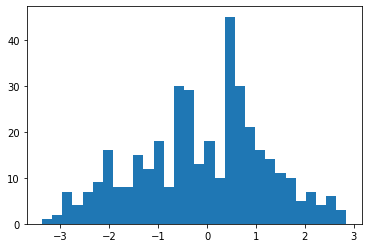

In [24]:
# Es mucho más grande... es decir que el modelo está claramente sobre entrenado

errvec_test = y_test - y_test_predicted

plt.hist(errvec_test, bins=30)
plt.show()

In [36]:
# Podemos jugar con los parámetros del regresor
# Vamos a bajar la máxima profundidad a 2,
# y vamos a bajar el número total de árboles a 20

reg2 = xgb.XGBRegressor(max_depth=2, learning_rate=0.1,
                         n_estimators=20)

reg2.fit(X_train, y_train)

y_train_predicted = reg2.predict(X_train)
y_test_predicted = reg2.predict(X_test)

print('Error cuadrático medio en train:', mean_squared_error(y_train_predicted, y_train))
print('Error cuadrático medio en test:', mean_squared_error(y_test_predicted, y_test))

[08:31:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Error cuadrático medio en train: 1.658437621479618
Error cuadrático medio en test: 1.9840329787422737


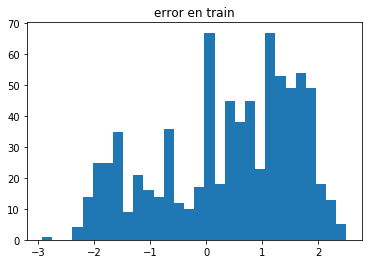

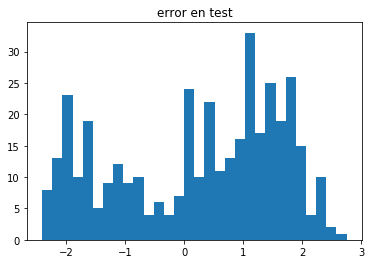

In [37]:
errvec_train = y_train - y_train_predicted

plt.title('error en train')
plt.hist(errvec_train, bins=30)
plt.show()

errvec_test = y_test - y_test_predicted

plt.title('error en test')
plt.hist(errvec_test, bins=30)
plt.show()

Ahora los errores son mucho más parecidos, lo cual es evidencia de que el modelo comete los mismos errores en ambos conjuntos de datos, por lo que el modelo no está sobre entrenado.